In [116]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import MultiStepLR
import numpy as np
import random
import torch.nn.utils
import textwrap
import re
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import math
import torch.nn.functional as F
from transformers import AutoTokenizer
from datasets import load_dataset, Dataset
import math
import datasets
from transformers import DataCollatorWithPadding
from torch.utils.data import DataLoader
from torch.profiler import profile, record_function, ProfilerActivity

In [117]:
torch.cuda.empty_cache()

In [118]:
import os



tokenized_dataset_path = os.getcwd() + '/tokenized_train_dataset'

print(os.path.isdir(tokenized_dataset_path))

def tokenization(example):
    
    # tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neo-125M")
    
    # tokenizer.pad_token = tokenizer.eos_token
    from transformers import AutoTokenizer
    tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-Instruct-v0.1")
    tokenized_output = tokenizer(example['text'], truncation=True)
    tokenized_output['input_ids'] = [tokens + [tokenizer.encode(tokenizer.eos_token)[1]] for tokens in tokenized_output['input_ids']]
    return tokenized_output

def chunk_examples(examples):
    window = 250
    all_tokens = [token for example in examples for token in example['input_ids']]
    chunks = [all_tokens[i:i + window] for i in range(0, len(all_tokens), window)]
    if len(chunks[-1]) != window:
        chunks = chunks[:-1]
    return Dataset.from_dict({"input_ids": chunks})

def generate_tokenized_dataset(train: bool=True) -> DataLoader:
    # tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neo-125M")
    tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-Instruct-v0.1")
    tokenizer.pad_token = tokenizer.eos_token
    if train:
        dataset_type = "train"
        tokenized_dataset_folder = 'tokenized_train_dataset'
        tokenized_dataset_path = os.getcwd() + '/' + tokenized_dataset_folder
    else:
        dataset_type = "validation"
        tokenized_dataset_folder = 'tokenized_validation_dataset'
        tokenized_dataset_path = os.getcwd() + '/tokenized_validation_dataset'
    
    print(os.getcwd())

    if os.path.isdir(tokenized_dataset_path):
        tokenized_entries = datasets.load_from_disk(tokenized_dataset_folder)
       
    else:
        dataset = load_dataset("roneneldan/TinyStories")
        dataset = dataset[dataset_type]
        updated_dataset = dataset#.map(chunk_examples, batched=True, remove_columns=dataset.column_names, num_proc=5)
        tokenized_entries = updated_dataset.map(tokenization, batched=True, num_proc=8)
        print(tokenized_entries)
        tokenized_entries = chunk_examples(tokenized_entries)
        # tokenized_entries = tokenized_entries.map(pad_tokens, batched=True, num_proc=8)
        # tokenized_entries = tokenized_entries.map(tokenization, batched=True, num_proc=8)
        tokenized_entries.save_to_disk(tokenized_dataset_folder)
       
        
    
    # data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")
    data_loader = DataLoader(tokenized_entries, batch_size=8, shuffle=False)#, collate_fn=data_collator)
    return data_loader
    # return tokenized_entries

True


In [119]:
from transformers import AutoTokenizer
# tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neo-125M")
tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-Instruct-v0.1")
# tokenizer.pad_token = tokenizer.eos_token

train_loader = generate_tokenized_dataset(True)
# entries = generate_tokenized_dataset(True)

tokenizer_config.json:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

c:\Users\vjsam\anaconda3\lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\vjsam\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

c:\Users\vjsam\Documents\UPenn\Fall 2023\ESE 546\Final Project


In [120]:
# print(len(train_loader['input_ids'][0]))

In [121]:
# print("len: " + str(len(entries['tokens'][4])))
# print(tokenizer.decode(entries['tokens'][4]))

# print("-------------")

# print("len: " + str(len(entries['tokens'][5])))
# print(tokenizer.decode(entries['tokens'][5]))

# print("-------------")

# print("len: " + str(len(entries['tokens'][6])))
# print(tokenizer.decode(entries['tokens'][6]))

In [122]:
# print(tokenizer.decode(tokenizer.encode(tokenizer.eos_token)[1]))
# print(tokenizer.eos_token)

In [123]:
# print(len(train_loader.sampler))
# print(len(train_loader))

In [124]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)



cuda


In [125]:
# input_feature_dim = m
# input_feature_dim = 50257
input_feature_dim = tokenizer.vocab_size
hidden_size = 256
# hidden_size = 2048

In [126]:
class TransformerModel(nn.Module):
    def __init__(self, input_feature_dim, d_model, num_heads, num_layers):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Embedding(input_feature_dim, d_model)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=d_model, nhead=num_heads, dropout=0.1,dim_feedforward=2048),
            num_layers=num_layers,
            norm=nn.LayerNorm(d_model),
        )
        self.fc = nn.Linear(d_model, input_feature_dim)
        self.pos_encoder = PositionalEncoding(d_model)

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, x):
        x = self.embedding(x)
        x = self.pos_encoder(x)
        mask = self.generate_square_subsequent_mask(len(x[0])).to(device)
        x = x.permute(1,0,2)
        x = self.transformer(x, mask)
        x = x.permute(1,0,2)
        x = self.fc(x)
        return x
    

class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, max_len: int = 5000):
        super().__init__()

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        
        x = x + (self.pe[:x.size(0)])
        return x

In [127]:
def trainLR(net, optimizer, criterion, train_loader, scheduler):
    model = net.to(device)
    train_loss = []
    lrs = []
    for k, input in enumerate(train_loader):
        if k >= 100:
            return train_loss, lrs
        # sequence = torch.tensor(input['input_ids']).to(device)
        sequence = torch.permute(torch.stack(input['input_ids']), (1,0)).to(device)
        model.train()
        labels = sequence[:,1:].contiguous().view(-1)
        output = model(sequence[:,:-1])
        
        output = output.view(-1, output.size(-1))
        
        loss = criterion(output, labels)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 2)
        optimizer.step()
        
        scheduler.step()
        lrs.append(scheduler.get_last_lr())
        train_loss.append(loss.item())

        del loss, output, labels

    return train_loss, lrs

In [128]:
losses = np.zeros(100)
all_lrs = np.zeros(100)
for i in range(10):
    print(i)
    num_heads = 10
    num_layers = 10
    transformer_model = TransformerModel(input_feature_dim, hidden_size-(hidden_size%num_heads), num_heads=num_heads, num_layers=num_layers).to(device)
    # transformer_model = TransformerModel(input_feature_dim, int(input_feature_dim/2) - (int(input_feature_dim/2) % 4)).to(device)
    # pad_token = tokenizer.encode(tokenizer.pad_token)[0]
    criterion = nn.CrossEntropyLoss()#ignore_index=pad_token)
    optimizer = optim.AdamW(transformer_model.parameters(), lr = 0.00001, betas=(0.9, 0.95))
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=1.1)


    loss, lrs = trainLR(transformer_model, optimizer, criterion, train_loader, scheduler)
    losses += np.array(loss)
    all_lrs = np.array(lrs)

losses /= 10
all_lrs /= 10

0
1
2
3
4
5
6
7
8
9


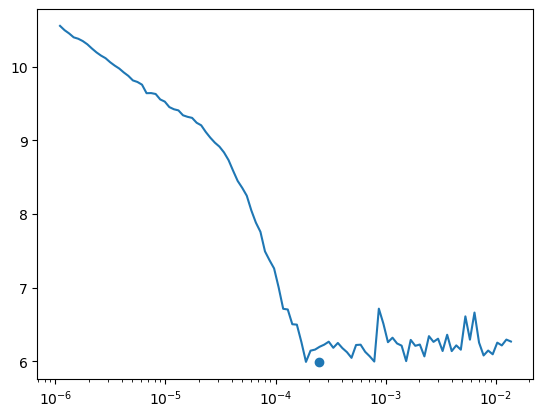

In [129]:
fig1, ax1 = plt.subplots()
ax1.set_xscale('log')
ax1.plot(all_lrs, losses)
ax1.scatter(0.00025, np.amin(losses))

In [130]:
print(len(train_loader)/5)

49483.0


In [131]:
def customScheduler(t, n_max, epochs, train_loader):
    T = epochs*len(train_loader)
    T0 = float(T/5)

    if t <= T0:
        return pow(10, -8) + n_max*t/T0
    else:
        return n_max*np.cos(np.pi/2*(t-T0)/(T-T0)) + pow(10, -10)

In [132]:
num_heads = 10
num_layers = 10
transformer_model = TransformerModel(input_feature_dim, hidden_size-(hidden_size%num_heads), num_heads=num_heads, num_layers=num_layers).to(device)
# transformer_model.load_state_dict(torch.load('transformer_base_training.pth'))
# transformer_model = TransformerModel(input_feature_dim, int(input_feature_dim/2) - (int(input_feature_dim/2) % 4)).to(device)
# pad_token = tokenizer.encode(tokenizer.pad_token)[0]
criterion = nn.CrossEntropyLoss()#ignore_index=pad_token)
optimizer = optim.AdamW(transformer_model.parameters(), lr = 0.000025, betas=(0.9, 0.95))
# scheduler = MultiStepLR(optimizer, milestones=[2500, 7000], gamma=0.1)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.98)
# train_temperature = 1.0


In [133]:
def softmax_with_temperature(logits, temperature):
    return F.softmax(logits / temperature, dim=-1)

In [134]:
# print(summary(transformer_model, (1,m)))
pytorch_total_params = sum(p.numel() for p in transformer_model.parameters())
print(pytorch_total_params)


28815480


In [135]:
# combined_string = dataset['train'][:]['text']

# batch_size = 250
# batches = [combined_string[i:i+batch_size][0] for i in range(0, len(combined_string), batch_size)]
# if len(batches[-1]) != batch_size:
#     batches.pop()

# char_1 = 0
# batches = batches
# for i in batches:
#     char_1 += len(i)
# print(len(batches))
# print(len(combined_string))
# # print(batches[-1])
# print(dataset['train'][-1])
# print(combined_string[-1])
# batches = dataset['train']
# chars = 0
# for i,batch in enumerate(batches):
#     chars += len(batch['text'])
# # print(i)
# print(char_1)
# print(chars)
# num_sequences = 30000

Iteration: 1000/247415
Iteration: 2000/247415
Iteration: 3000/247415
Iteration: 4000/247415
Iteration: 5000/247415
Iteration: 6000/247415
Iteration: 7000/247415
Iteration: 8000/247415
Iteration: 9000/247415
Iteration: 10000/247415


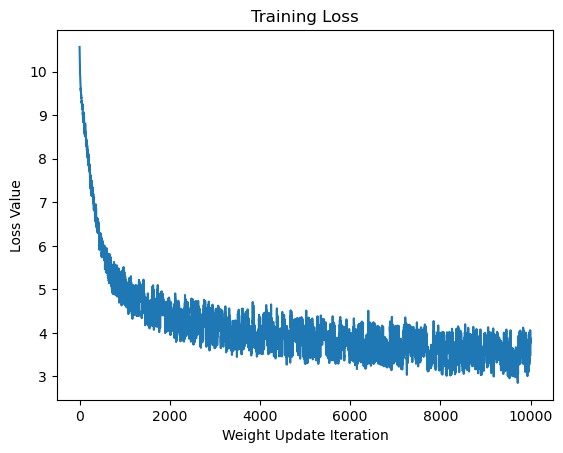

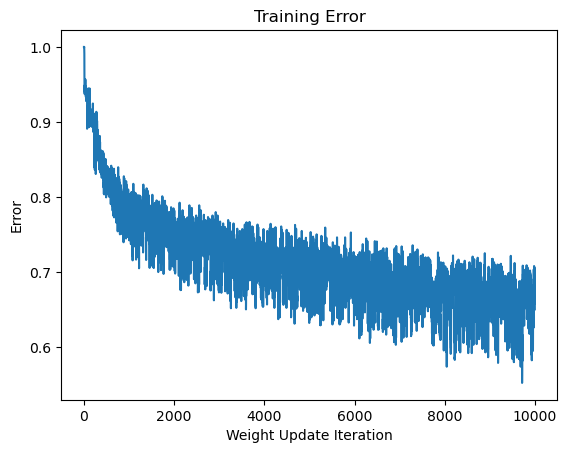

Iteration: 11000/247415
Iteration: 12000/247415
Iteration: 13000/247415


KeyboardInterrupt: 

In [136]:
num_epochs = 1
training_loss_values = []
training_error_values = []
validation_loss_values = []
validation_error_values = []
x_vals = []
lrs = []
x_val = 1
validation_x_vals = []
num_validation_seq = 5


for epoch in range(num_epochs):

    # loss_accumulator = 0
    # error_accumulator = 0
    
    for i,input in enumerate(train_loader):
        # with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], 
        #              record_shapes=True, 
        #              profile_memory=True, 
        #              use_cuda=torch.cuda.is_available()) as prof:
    # for i, input in enumerate(batches):
            # input = input['text']
            lr = customScheduler(i, 0.000025, num_epochs, train_loader)
            lrs.append(lr)
            for g in optimizer.param_groups:
                g[lr] = lr
            # sequence = torch.tensor(input['input_ids']).to(device)
            sequence = torch.permute(torch.stack(input['input_ids']), (1,0)).to(device)
            # attn_mask = torch.tensor(input['attention_mask'])[:, 1:].to(device)
            # print(attn_mask.shape)
            # print(sequence.shape)
            transformer_model.train()
            # tokens = encoding.encode(input)
            # sequence = torch.tensor(tokens).long().to(device)
            labels = sequence[:,1:].contiguous().view(-1)
            output = transformer_model(sequence[:,:-1])
            # print(output.shape)
            # pad_tensor = torch.zeros_like(output)
            # pad_tensor[:, :, pad_token] = 1
            # attn_mask = attn_mask.unsqueeze(2).repeat(1,1,50257)
            # # print(attn_mask.unsqueeze(2).repeat(1,1,50257).shape)
            # output = torch.where(attn_mask==1, output, pad_tensor)
            
            output = output.view(-1, output.size(-1))
            
            loss = criterion(output,labels)
            # softmaxed_logits = softmax_with_temperature(output, train_temperature)
            # loss = nn.NLLLoss()(torch.log(softmaxed_logits), labels)
            optimizer.zero_grad()
            loss.backward()
            # torch.nn.utils.clip_grad_norm_(rnn.parameters(), 15.0)
            # loss_accumulator += loss.item()
            optimizer.step()
            # training_loss_values.append(loss.item())
            
            predicted_labels = torch.argmax(output,dim=1)
            training_error = 1.0 - (labels == predicted_labels).sum()/(len(labels))
            # training_error_values.append(training_error.item())
            # error_accumulator += training_error.item()

            # x_vals.append(x_val)

            # if x_val % 50 == 0:  # If 50 iterations have passed
            #     avg_loss = loss_accumulator / 50.0
            #     avg_error = error_accumulator / 50.0
            #     training_loss_values.append(avg_loss)
            #     training_error_values.append(avg_error)
            #     x_vals.append(x_val)
            #     # Reset the accumulators
            #     loss_accumulator = 0
            #     error_accumulator = 0

            training_loss_values.append(loss.item())
            training_error_values.append(training_error.item())

            if (x_val % 1000) == 0:
                transformer_model.eval()
                print('Iteration: {}/{}'.format(x_val, len(train_loader)))
                # torch.save(transformer_model.state_dict(), 'transformer_base_training_extended.pth')
            
            if (x_val % 10000) == 0:
                x_vals = np.arange(x_val)
                plt.figure()
                plt.plot(x_vals,training_loss_values)
                plt.xlabel('Weight Update Iteration')
                plt.ylabel('Loss Value')
                plt.title('Training Loss')
                plt.figure()
                plt.plot(x_vals, training_error_values)
                plt.xlabel('Weight Update Iteration')
                plt.ylabel('Error')
                plt.title('Training Error')
                plt.show()
            
            # if x_val==20000:
            #     break
                
            x_val +=1

            del loss, output, labels
        # print(prof.key_averages().table(sort_by="cuda_time_total"))
            # scheduler.step()

[1e-08, 1.050522401632884e-08, 1.101044803265768e-08, 1.1515672048986521e-08, 1.2020896065315361e-08, 1.2526120081644201e-08, 1.3031344097973042e-08, 1.3536568114301882e-08, 1.4041792130630722e-08, 1.4547016146959563e-08, 1.5052240163288403e-08, 1.555746417961724e-08, 1.6062688195946083e-08, 1.6567912212274925e-08, 1.7073136228603764e-08, 1.7578360244932602e-08, 1.8083584261261444e-08, 1.8588808277590286e-08, 1.9094032293919125e-08, 1.9599256310247963e-08, 2.0104480326576805e-08, 2.0609704342905647e-08, 2.1114928359234486e-08, 2.1620152375563324e-08, 2.2125376391892166e-08, 2.2630600408221005e-08, 2.3135824424549847e-08, 2.3641048440878685e-08, 2.4146272457207524e-08, 2.465149647353637e-08, 2.5156720489865208e-08, 2.566194450619405e-08, 2.616716852252289e-08, 2.6672392538851727e-08, 2.717761655518057e-08, 2.7682840571509408e-08, 2.818806458783825e-08, 2.8693288604167088e-08, 2.9198512620495927e-08, 2.970373663682477e-08, 3.020896065315361e-08, 3.071418466948245e-08, 3.121940868581129e-

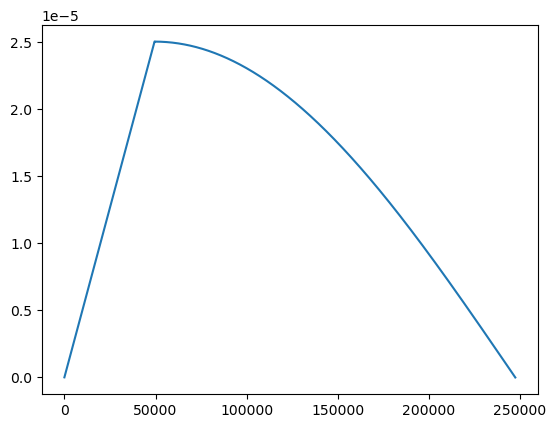

In [ ]:
plt.plot(lrs)

print(lrs)

In [ ]:
# torch.save(transformer_model.state_dict(), 'transformer_base_training_extended.pth')
# print('Model saved')

Model saved


<Figure size 640x480 with 0 Axes>

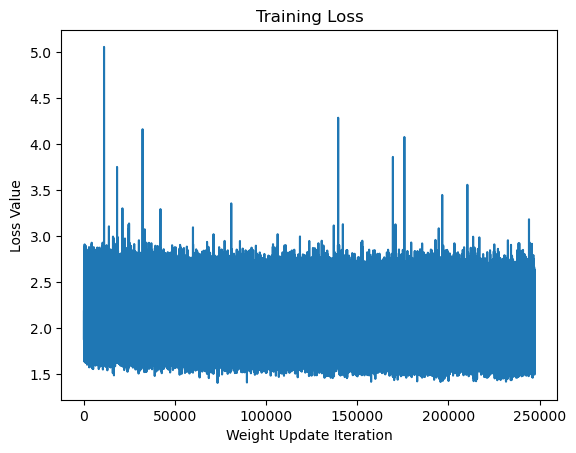

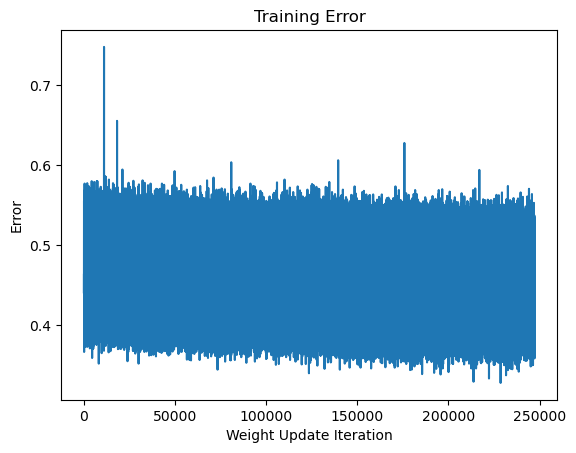

<Figure size 640x480 with 0 Axes>

In [ ]:
# output,_ = rnn(input[40].to(device))
# output = [unique_chars[i] for i in torch.argmax(output, dim=1).tolist()]
# output = torch.tensor(unique_chars)
# [torch.argmax(output, dim=1)]
# print(batches[40])
# # print((output))
# # print(output)
# print(error)
# print(current_labels)
# print(torch.argmax(output,dim=1))
# test = [1,2,3,4,5]

# training_error_values = [i.cpu().item() for i in training_error_values]
# validation_error_values = [i.cpu().item() for i in validation_error_values]
# validation_loss_values = [i.cpu().item() for i in validation_loss_values]
x_vals = np.arange(x_val-1)

plt.figure()
plt.plot(x_vals,training_loss_values)
plt.xlabel('Weight Update Iteration')
plt.ylabel('Loss Value')
plt.title('Training Loss')
plt.figure()
plt.plot(x_vals, training_error_values)
plt.xlabel('Weight Update Iteration')
plt.ylabel('Error')
plt.title('Training Error')
plt.figure()
# plt.plot(validation_x_vals, validation_loss_values)
# plt.xlabel('Weight Update Iteration')
# plt.ylabel('Loss Value')
# plt.title('Validation Loss')
# plt.figure()
# plt.plot(validation_x_vals, validation_error_values)
# plt.xlabel('Weight Update Iteration')
# plt.ylabel('Error')
# plt.title('Validation Error')
# plt.show()

In [ ]:
test_temperature = 0.9
transformer_model.eval()
capital_letters = [chr(i) for i in range(65, 91)]
example_sentences = []
#initialize = ["I went to the store."]
# initialize = ['Alice and Jack walked up the street and met a girl in a red dress. The girl said to them, ”Hi, I’m Jane. What are your names?”']
initialize = ['Alice was so tired when she got back home so she went']
# initialize = ['Tom and Jane are friends. One day, Jane goes to Tom’s house. Tom has a big pot of soup. He wants to share it with Jane. “Jane, do you want some soup?” Tom asks. “Yes, please. It looks yummy,” Jane says. Tom pours some soup into two bowls. He gives one bowl to Jane. Jane takes a spoonful of soup, but then she makes a face. The soup is']
inference_tokens = 100
for i in range(1):
    sentence = initialize[i]
    tokenized_sentence = tokenizer.encode(sentence)
    # print(len(tokenized_sentence))
    next_token = torch.tensor(tokenized_sentence).long().unsqueeze(0).to(device)
    for j in range(inference_tokens):
        next_token = transformer_model(next_token)
        # print(next_char.shape)
        # print(next_char.shape)
        next_softmax = softmax_with_temperature(next_token, test_temperature)
        # predicted_char = torch.argmax(next_softmax,dim=1)
        predicted_token = torch.multinomial(next_softmax[0][-1],1)
        if predicted_token.item()==tokenizer.eos_token:
            break
        # letter = unique_chars[predicted_char[-1]]
        # print('"' + tokenizer.decode(predicted_char) + '"')
        # letter = tokenizer.decode([predicted_char.item()])
        # sentence += letter
        # next_char = torch.tensor(tokenize(sentence)).long().to(device)
        tokenized_sentence.append(predicted_token)
        next_token = torch.tensor(tokenized_sentence).unsqueeze(0).long().to(device)
    sentence = tokenizer.decode(next_token[0].cpu().numpy())
    example_sentences.append(sentence)
example_sentences = np.array(example_sentences)
print(example_sentences[0])
# print(example_sentences[1])
# print(example_sentences[2])
# print(example_sentences[3])
# print(example_sentences[4])

<s> Alice was so tired when she got back home so she went to sleep. She put on her lovely dress, opened the box and put it on. She slept and played until the sun started to set. 

Alice was so thirsty! She took a drink from her plate and found a drink. It was so jolly! 

Then she saw a very tasty snack. She asked her mom, "Can I have one?"

Her mom smiled and said, "Yes, please, but be careful when you
